In [2]:
import pandas as pd
import numpy as np
from random import seed

np.random.seed(0)

# Load dataset
try:
    df = pd.read_csv('breast-cancer.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: 'breast-cancer.csv' file not found.")

# Display first few rows
if 'df' in locals():
    print("----------- First few rows of the dataset -----------")
    # print(df.head())
    print("-----------------------------------------------------")

    # Droping irrevelant colums and cleaning
    # Droping 'id' and 'Unnamed: 32' columns
    cols_to_drop = ['id', 'Unnamed: 32']
    df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    # Mapping diagnosis (M: Malignant, B: Benign) to numerical values (1, 0)
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

    print("----------- Cleaned dataset preview -----------")
    print(df.head())
    print("------------------------------------------------")

    # Seperate features (x) and target (y)
    # Convert dataframes to numpy arrays for custom alghorithm implementation
    x = df.drop('diagnosis', axis=1).values
    y = df['diagnosis'].values

    print(f"Features shape: {x.shape}")
    print(f"Target shape: {y.shape}")

    # Custom Train-Test Split (80% Train, 20% Test)
    def custom_train_test_split(X, y, test_size=0.2, seed=42):
        """Splits data into training and testing sets without using sklearn."""
        np_samples = X.shape[0]
        np_test = int(np_samples * test_size)
        
        # Set random seed for reproducibility
        np.random.seed(seed)
        indices = np.arange(np_samples)
        np.random.shuffle(indices)

        # Split indices
        test_indices = indices[:np_test]
        train_indices = indices[np_test:]

        # Apply indices
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]
        
        return X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = custom_train_test_split(x, y, test_size=0.2, seed=42)

    print(f"\nDimensions after custom train-test split:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

else:
    print("Dataset not loaded; skipping further processing.")
    X_train, X_test, y_train, y_test = None, None, None, None






Data loaded successfully.
----------- First few rows of the dataset -----------
-----------------------------------------------------
----------- Cleaned dataset preview -----------
   diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0


--- Performing Custom Grid Search with Cross-Validation on Unscaled Data (VERBOSE) ---
Generated 5 folds with sizes: [92, 91, 91, 91, 91]

Testing k = 1

 Fold 1/5: Train size = 364, Val size = 92

  Val sample (global idx 373, local val idx 0):
    Distances & labels of k=1 closest neighbors:
      1. dist=17.2845, label=0, train_local_idx=181
  Neighbor label counts (by value): [1]
    Predicted label: 0 (true: 0)

  Val sample (global idx 39, local val idx 1):
    Distances & labels of k=1 closest neighbors:
      1. dist=12.0581, label=0, train_local_idx=227
  Neighbor label counts (by value): [1]
    Predicted label: 0 (true: 0)
  Correct: 87/92  ->  Accuracy: 0.9457
 Fold 1 accuracy: 0.9457

 Fold 2/5: Train size = 365, Val size = 91

  Val sample (global idx 17, local val idx 0):
    Distances & labels of k=1 closest neighbors:
      1. dist=186.6176, label=1, train_local_idx=40
  Neighbor label counts (by value): [0 1]
    Predicted label: 1 (true: 1)

  Val sample (global idx

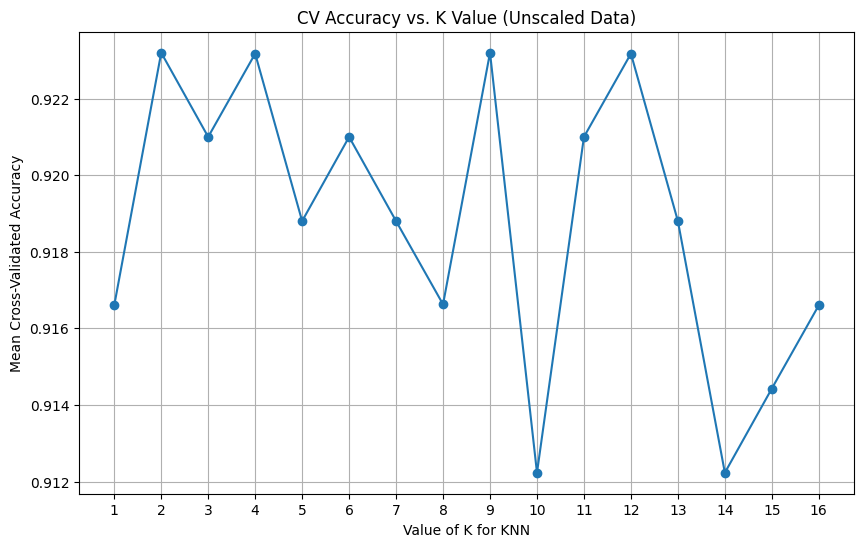

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Custom KNN Core Functions (verbose-friendly) ---
def euclidean_distance(x1, x2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt(np.sum((x1 - x2) ** 2))

def get_neighbors_with_distances(X_train, y_train, x_test_row, k):
    """
    Return a sorted list of (distance, label, train_index) tuples for X_train
    and the labels of the k closest neighbors.
    """
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(x_test_row, X_train[i])
        distances.append((dist, int(y_train[i]), int(i)))  # (distance, label, train_idx)

    # sort by distance
    distances.sort(key=lambda x: x[0])

    # neighbors: first k tuples
    neighbors = distances[:k]
    neighbors_labels = [t[1] for t in neighbors]
    return neighbors, neighbors_labels

def predict_classification(neighbors_labels, verbose=False):
    """Predict the class based on majority vote from neighbors' labels."""
    counts = np.bincount(neighbors_labels)
    if verbose:
        print(f"  Neighbor label counts (by value): {counts}")
    return int(np.argmax(counts))

# Simple accuracy
def accuracy_score(y_true, y_pred, verbose=False):
    correct = np.sum(y_true == y_pred)
    acc = correct / len(y_true)
    if verbose:
        print(f"  Correct: {correct}/{len(y_true)}  ->  Accuracy: {acc:.4f}")
    return acc

# --- Custom K-Fold split (unchanged but prints summary) ---
def custom_k_fold_split(X, y, n_splits=5, seed=42, verbose=False):
    np.random.seed(seed)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1

    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    if verbose:
        sizes = [len(f) for f in folds]
        print(f"Generated {len(folds)} folds with sizes: {sizes}")
    return folds

# --- Grid search + CV with step-by-step prints ---
def custom_grid_search_cv_verbose(X, y, k_range, n_splits=5, seed=42, verbose=True, max_display=3):
    folds = custom_k_fold_split(X, y, n_splits=n_splits, seed=seed, verbose=verbose)
    mean_scores = {}

    for k in k_range:
        if verbose:
            print("\n" + "="*70)
            print(f"Testing k = {k}")
            print("="*70)
        fold_accuracies = []

        # Iterate folds
        for fold_idx in range(n_splits):
            test_indices = folds[fold_idx]
            train_indices = np.concatenate([folds[j] for j in range(n_splits) if j != fold_idx])

            X_train_fold, y_train_fold = X[train_indices], y[train_indices]
            X_val_fold, y_val_fold = X[test_indices], y[test_indices]

            if verbose:
                print(f"\n Fold {fold_idx+1}/{n_splits}: Train size = {len(train_indices)}, Val size = {len(test_indices)}")

            # Predict each validation sample (with controlled printing)
            y_pred_fold = []
            for i_val, global_idx in enumerate(test_indices):
                x_val = X_val_fold[i_val]
                neighbors, neighbor_labels = get_neighbors_with_distances(X_train_fold, y_train_fold, x_val, k)

                # Print details for first `max_display` validation samples in this fold
                if verbose and i_val < max_display:
                    print(f"\n  Val sample (global idx {global_idx}, local val idx {i_val}):")
                    # show small summary rather than full feature vector
                    print(f"    Distances & labels of k={k} closest neighbors:")
                    for rank, (dist, lbl, train_local_idx) in enumerate(neighbors, start=1):
                        print(f"      {rank}. dist={dist:.4f}, label={lbl}, train_local_idx={train_local_idx}")
                
                pred = predict_classification(neighbor_labels, verbose=(verbose and i_val < max_display))
                y_pred_fold.append(pred)
                if verbose and i_val < max_display:
                    print(f"    Predicted label: {pred} (true: {y_val_fold[i_val]})")

            y_pred_fold = np.array(y_pred_fold)
            acc = accuracy_score(y_val_fold, y_pred_fold, verbose=(verbose))
            fold_accuracies.append(acc)
            if verbose:
                print(f" Fold {fold_idx+1} accuracy: {acc:.4f}")

        mean_scores[k] = np.mean(fold_accuracies)
        if verbose:
            print(f"\n Mean CV accuracy for k={k}: {mean_scores[k]:.4f}")

    # best k
    best_k = max(mean_scores, key=mean_scores.get)
    best_score = mean_scores[best_k]
    if verbose:
        print("\n" + "#"*70)
        print(f"BEST k found: {best_k} with mean CV accuracy = {best_score:.4f}")
        print("#"*70)
    return best_k, best_score, mean_scores

# --- Execution for Unscaled Data (verbose) ---
k_range = list(range(1, 17))  # [1..16]

print("\n--- Performing Custom Grid Search with Cross-Validation on Unscaled Data (VERBOSE) ---")
best_k_unscaled, best_score_unscaled, mean_scores_unscaled = custom_grid_search_cv_verbose(
    X_train, y_train, k_range, n_splits=5, seed=42, verbose=True, max_display=2
)

print(f"\nFinal result (unscaled): Best k = {best_k_unscaled}, Mean CV accuracy = {best_score_unscaled:.4f}")

# Plot CV scores
k_values = list(mean_scores_unscaled.keys())
scores = list(mean_scores_unscaled.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-')
plt.title('CV Accuracy vs. K Value (Unscaled Data)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Store results
results_unscaled = {'K': best_k_unscaled, 'CV_Accuracy': best_score_unscaled}


In [ ]:
# Custom Standard Scaler Implementation

class CustomStandardScaler:
    """A custom implementation of StandardScaler using numpy."""
    def fit(self, X):
        """Compute the mean and std to be used for later scaling."""
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        # To avoid division by zero
        self.std_[self.std_ == 0] = 1e-7
        return self
    
    def transform(self, X):
        """Perform standardization by centering and scaling."""
        return (X - self.mean_) / self.std_ 
    
    def fir_transform(self, X):
        """Fit to data, then transform it."""
        self.fit(X)
        return self.transform(X)
    
# --- Application of Correct Scaling ---
# X_train and X_test are the unscaled data from step 1

scaler = CustomStandardScaler()

# 1. Fit Only on traning datatransform data
X_train_scaled = scaler.fir_transform(X_train)

# 2. Transform test data using the mean std learned from the training data
X_test_scaled = scaler.fir_transform(X_test)

print("Dimensions of scaled data:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

print("\nStarting custom Grid Search (5-Fold CV) for K on SCALED training data...")

# Reuse the custom_grid_search_cv function from Step 1.2
best_k_scaled, best_score_scaled, mean_scores_scaled = custom_grid_search_cv(
    X_train_scaled, y_train, k_range, n_splits=5
)

print(f"\n--- Results for SCALED Data ---")
print(f"Optimal K (Scaled Data): {best_k_scaled}")
print(f"Best CV Accuracy Score: {best_score_scaled:.4f}")

# --- Plotting the CV scores vs K ---
k_values_scaled = list(mean_scores_scaled.keys())
scores_scaled = list(mean_scores_scaled.values())

plt.figure(figsize=(10, 6))
plt.plot(k_values_scaled, scores_scaled, marker='o', linestyle='-', color='green')
plt.title('CV Accuracy vs. K Value (Scaled Data)')
plt.xlabel('Value of K for KNN')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.xticks(k_values_scaled)
plt.grid(True)
plt.show()

# Storing results for later comparison
results_scaled = {'K': best_k_scaled, 'CV_Accuracy': best_score_scaled}

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ---------- Helper functions (verbose-friendly) ----------
def custom_corr_matrix_verbose(X_data, verbose=True):
    """Return correlation matrix and optionally print summary/top correlated pairs."""
    n_features = X_data.shape[1]
    corr_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(i, n_features):
            col_i = X_data[:, i]
            col_j = X_data[:, j]
            mean_i = np.mean(col_i)
            mean_j = np.mean(col_j)
            std_i = np.std(col_i)
            std_j = np.std(col_j)
            if std_i * std_j == 0:
                rho = 0.0
            else:
                covariance = np.mean((col_i - mean_i) * (col_j - mean_j))
                rho = covariance / (std_i * std_j)
            corr_matrix[i, j] = rho
            corr_matrix[j, i] = rho

    if verbose:
        print(f"\nCorrelation matrix shape: {corr_matrix.shape}")
        # Print small sample of matrix
        n = min(8, corr_matrix.shape[0])
        print("Top-left submatrix (rounded):")
        print(np.round(corr_matrix[:n, :n], 3))

        # Show top correlated pairs (abs corr, excluding self-pairs)
        pairs = []
        n_feats = corr_matrix.shape[0]
        for a in range(n_feats):
            for b in range(a+1, n_feats):
                pairs.append((abs(corr_matrix[a,b]), corr_matrix[a,b], a, b))
        pairs.sort(reverse=True, key=lambda x: x[0])
        print("\nTop 8 feature pairs by absolute correlation (abs_corr, corr, i, j):")
        for item in pairs[:8]:
            print(item)
    return corr_matrix

def get_neighbors_with_distances(X_train, y_train, x_test_row, k):
    """Return sorted (distance,label,train_idx) neighbors and labels list."""
    distances = []
    for i in range(len(X_train)):
        dist = np.sqrt(np.sum((x_test_row - X_train[i])**2))
        distances.append((dist, int(y_train[i]), int(i)))
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    labels = [t[1] for t in neighbors]
    return neighbors, labels

def predict_majority(neighbor_labels):
    counts = np.bincount(neighbor_labels)
    return int(np.argmax(counts))

# A verbose CV/grid search specialized to show fold-level neighbor examples
def custom_grid_search_cv_verbose(X, y, k_range, n_splits=5, seed=42,
                                  max_val_samples_show=2, verbose=True):
    np.random.seed(seed)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    folds = []
    cur = 0
    for fs in fold_sizes:
        folds.append(indices[cur:cur+fs])
        cur += fs

    if verbose:
        print(f"\nCustom K-Fold with n_splits={n_splits}; fold sizes = {[len(f) for f in folds]}")

    mean_scores = {}
    per_k_fold_accuracies = defaultdict(list)

    for k in k_range:
        if verbose:
            print("\n" + "#"*60)
            print(f"Evaluating k = {k}")
            print("#"*60)
        fold_accuracies = []
        for fold_i in range(n_splits):
            test_idx = folds[fold_i]
            train_idx = np.concatenate([folds[j] for j in range(n_splits) if j != fold_i])

            X_tr = X[train_idx]; y_tr = y[train_idx]
            X_val = X[test_idx]; y_val = y[test_idx]

            if verbose:
                print(f"\n Fold {fold_i+1}/{n_splits}: train={len(train_idx)} val={len(test_idx)}")

            # Predict for all val samples, but only show detailed neighbor info for first few
            y_pred_val = []
            for vi in range(len(X_val)):
                x_val = X_val[vi]
                neighbors, n_labels = get_neighbors_with_distances(X_tr, y_tr, x_val, k)
                pred = predict_majority(n_labels)
                y_pred_val.append(pred)

                # Detailed printing for a subset
                if verbose and vi < max_val_samples_show:
                    global_val_idx = test_idx[vi]
                    print(f"  Val sample local_idx={vi} global_idx={global_val_idx} true={int(y_val[vi])} pred={pred}")
                    print("   Neighbors (rank: dist, label, train_local_idx):")
                    for r, (d, lab, tidx) in enumerate(neighbors, start=1):
                        print(f"    {r}: {d:.4f}, {lab}, train_idx_local={tidx}")

            y_pred_val = np.array(y_pred_val)
            acc = np.mean(y_pred_val == y_val)
            fold_accuracies.append(acc)
            per_k_fold_accuracies[k].append(acc)
            if verbose:
                print(f"  Fold {fold_i+1} accuracy: {acc:.4f}")

        mean_scores[k] = np.mean(fold_accuracies)
        if verbose:
            print(f"\n Mean CV accuracy for k={k}: {mean_scores[k]:.4f}")
            print(" Fold accuracies:", np.round(fold_accuracies, 4))

    # print summary table
    if verbose:
        print("\n=== SUMMARY: mean CV accuracies per k ===")
        for k in sorted(mean_scores.keys()):
            print(f" k={k:2d} -> mean_acc={mean_scores[k]:.4f}  fold_accs={np.round(per_k_fold_accuracies[k],4)}")

    best_k = max(mean_scores, key=mean_scores.get)
    best_score = mean_scores[best_k]
    return best_k, best_score, mean_scores, per_k_fold_accuracies

# ---------- Verbose Feature Selection + Scaling + Grid Search ----------
def run_feature_selection_and_verbose_cv(X_train, X_test, y_train, y_test,
                                         selected_indices_final,
                                         n_splits=5, k_range=list(range(1,17)),
                                         verbose=True, max_val_samples_show=2):
    # 1) Correlation analysis (verbose)
    print("\n--- Correlation analysis on MEAN/SE/WORST groups ---")
    # groups are assumed as 0-9, 10-19, 20-29
    grp_mean = X_train[:, :10]
    grp_se = X_train[:, 10:20]
    grp_worst = X_train[:, 20:30]

    corr_mean = custom_corr_matrix_verbose(grp_mean, verbose=verbose)
    corr_se = custom_corr_matrix_verbose(grp_se, verbose=verbose)
    corr_worst = custom_corr_matrix_verbose(grp_worst, verbose=verbose)

    # show features with high abs-correlation inside MEAN (threshold 0.9)
    def list_high_pairs(corr, thresh=0.9, label="group"):
        pairs = []
        n = corr.shape[0]
        for i in range(n):
            for j in range(i+1, n):
                if abs(corr[i,j]) >= thresh:
                    pairs.append((i, j, corr[i,j]))
        if verbose:
            print(f"\nHighly correlated pairs in {label} (|corr| >= {thresh}): {pairs}")
        return pairs

    list_high_pairs(corr_mean, 0.9, "MEAN")
    list_high_pairs(corr_se, 0.9, "SE")
    list_high_pairs(corr_worst, 0.9, "WORST")

    # 2) show selection reason & display sample values before reduction
    print("\n--- Selected feature indices (final) ---")
    print(selected_indices_final)
    print("\nExample rows (first 3) from X_train BEFORE selection (showing selected cols):")
    print(np.round(X_train[:3, selected_indices_final], 4))

    # 3) create reduced datasets
    X_tr_sel = X_train[:, selected_indices_final]
    X_te_sel = X_test[:, selected_indices_final]
    print(f"\nReduced shapes -> X_tr_sel: {X_tr_sel.shape}, X_te_sel: {X_te_sel.shape}")

    # 4) Scaling (fit on train only) and show means/std before & after
    scaler = CustomStandardScaler()
    print("\nFitting CustomStandardScaler on reduced training data...")
    scaler.fit(X_tr_sel)
    print(" Learned means (first 10 shown):", np.round(scaler.mean_[:min(10,len(scaler.mean_))], 4))
    print(" Learned stds  (first 10 shown):", np.round(scaler.std_[:min(10,len(scaler.std_))], 4))

    X_tr_sel_scaled = scaler.transform(X_tr_sel)
    X_te_sel_scaled = scaler.transform(X_te_sel)
    print("\nExample rows (first 3) from X_train AFTER scaling (selected cols):")
    print(np.round(X_tr_sel_scaled[:3, :], 4))

    # 5) Run verbose grid search (k-fold CV) on selected & scaled data
    print("\n--- Running verbose grid search (CV) on SCALED & SELECTED features ---")
    best_k, best_score, mean_scores, per_k_fold_accuracies = custom_grid_search_cv_verbose(
        X_tr_sel_scaled, y_train, k_range, n_splits=n_splits, seed=42,
        max_val_samples_show=max_val_samples_show, verbose=verbose
    )

    print("\nFinal result for SELECTED & SCALED data:")
    print(f" Best k = {best_k}, Best mean CV accuracy = {best_score:.4f}")

    # 6) Final evaluation on withheld X_test (scaled)
    print("\n--- Final evaluation on held-out X_test (selected + scaled) ---")
    y_pred_test = knn_predict(X_tr_sel_scaled, y_train, X_te_sel_scaled, best_k)
    test_acc = np.mean(y_pred_test == y_test)
    print(f" Test accuracy with best_k={best_k}: {test_acc:.4f}")

    return {
        "selected_indices": selected_indices_final,
        "best_k": best_k,
        "best_cv_score": best_score,
        "mean_scores": mean_scores,
        "per_k_fold_accuracies": per_k_fold_accuracies,
        "test_accuracy": test_acc
    }

# ----------------- Usage -----------------
# paste your selected_indices_final (e.g., [0,1,4,7,10,20,27])
# and call the function:
verbose_results = run_feature_selection_and_verbose_cv(
    X_train, X_test, y_train, y_test,
    selected_indices_final=[0,1,4,7,10,20,27],
    n_splits=5,
    k_range=list(range(1,17)),
    verbose=True,
    max_val_samples_show=2
)



--- Correlation analysis on MEAN/SE/WORST groups ---

Correlation matrix shape: (10, 10)
Top-left submatrix (rounded):
[[1.    0.314 0.998 0.987 0.172 0.477 0.647 0.812]
 [0.314 1.    0.32  0.309 0.009 0.229 0.283 0.29 ]
 [0.998 0.32  1.    0.986 0.209 0.529 0.688 0.842]
 [0.987 0.309 0.986 1.    0.179 0.47  0.659 0.814]
 [0.172 0.009 0.209 0.179 1.    0.672 0.537 0.564]
 [0.477 0.229 0.529 0.47  0.672 1.    0.877 0.825]
 [0.647 0.283 0.688 0.659 0.537 0.877 1.    0.915]
 [0.812 0.29  0.842 0.814 0.564 0.825 0.915 1.   ]]

Top 8 feature pairs by absolute correlation (abs_corr, corr, i, j):
(np.float64(0.9978612204503524), np.float64(0.9978612204503524), 0, 2)
(np.float64(0.9866404651344434), np.float64(0.9866404651344434), 0, 3)
(np.float64(0.9859712185460177), np.float64(0.9859712185460177), 2, 3)
(np.float64(0.9146225304758868), np.float64(0.9146225304758868), 6, 7)
(np.float64(0.8773477978263154), np.float64(0.8773477978263154), 5, 6)
(np.float64(0.842120668591572), np.float64(0.84

NameError: name 'CustomStandardScaler' is not defined